Model Machine Learning Time Series Mexico City Temperature in 1995 - 2014

In [58]:
#read dataset
import pandas as pd
df = pd.read_csv('city_temperature.csv')
df.head()

/tmp/ipykernel_3280/2402460373.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('city_temperature.csv')


,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


In [59]:
df = df[df.City == 'Mexico City']
df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
1212930,North America,Mexico,NaN,Mexico City,1,1,1995,57.7
1212931,North America,Mexico,NaN,Mexico City,1,2,1995,56.1
1212932,North America,Mexico,NaN,Mexico City,1,3,1995,57.6
1212933,North America,Mexico,NaN,Mexico City,1,4,1995,57.3
1212934,North America,Mexico,NaN,Mexico City,1,5,1995,58.8


In [60]:
df.reset_index(drop=True, inplace=True)
df.drop(columns=['Region','Country','State','City'], inplace = True)
df.head()

,Month,Day,Year,AvgTemperature
0,1,1,1995,57.7
1,1,2,1995,56.1
2,1,3,1995,57.6
3,1,4,1995,57.3
4,1,5,1995,58.8


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9265 entries, 0 to 9264
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Month           9265 non-null   int64  
 1   Day             9265 non-null   int64  
 2   Year            9265 non-null   int64  
 3   AvgTemperature  9265 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 289.7 KB


In [62]:
df['date'] = pd.to_datetime(df.apply(lambda x:'%s-%s-%s' % (int(x['Year']), int(x['Month']), int(x['Day'])), axis=1))
df.drop(columns=['Year','Month','Day'], inplace = True)
df.head()

,AvgTemperature,date
0,57.7,1995-01-01
1,56.1,1995-01-02
2,57.6,1995-01-03
3,57.3,1995-01-04
4,58.8,1995-01-05


In [63]:
#lihat outlier
df.boxplot('AvgTemperature')

<AxesSubplot:>

In [64]:
#outlier removal
import numpy as np
for x in ['AvgTemperature'] :
  q75,q25 = np.percentile(df.loc[:,x],[75,25])
  intr_qr = q75-q25
 
  max = q75+(1.5*intr_qr)
  min = q25-(1.5*intr_qr)
 
  df.loc[df[x] < min,x] = df['AvgTemperature'].mean()
  df.loc[df[x] > max,x] = df['AvgTemperature'].mean()

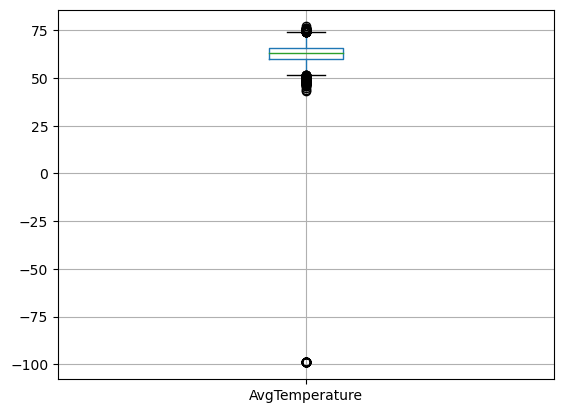

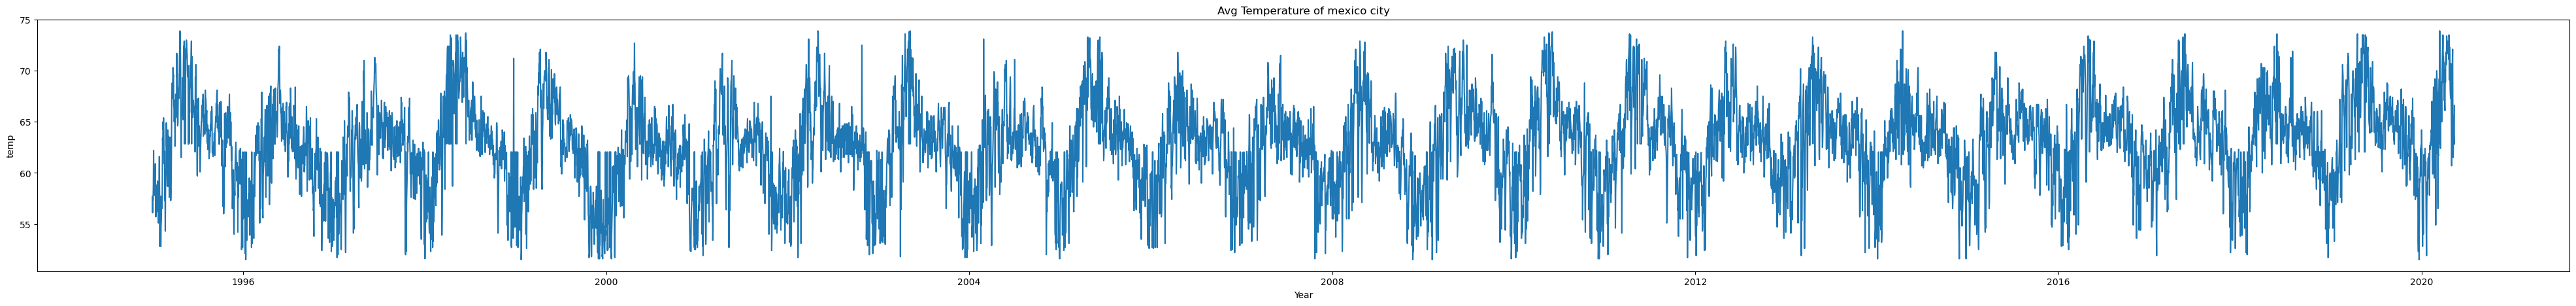

In [65]:
#plot time series
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(50,5))
plt.plot(df['date'],df['AvgTemperature'])
plt.title('Avg Temperature of mexico city')
plt.xlabel('Year')
plt.ylabel('temp')
plt.show()

In [66]:
#buat function windowed
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [67]:
#bagi dataset menjadi train dan label
from sklearn.model_selection import train_test_split

x = df['date']
y = df['AvgTemperature']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [68]:
#buat model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

train_set = windowed_dataset(y_train, window_size=64, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(y_test, window_size=64, batch_size=100, shuffle_buffer=1000)

model = Sequential([
  LSTM(60, return_sequences=True),
  LSTM(60),
  Dense(30, activation="relu"),
  Dense(10, activation="relu"),
  Dense(1),
])

model.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9),
  metrics = ['mae'])

/home/abie/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [69]:
#buat callbacks
MAE = (df['AvgTemperature'].max() - df['AvgTemperature'].min()) * 0.1

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<MAE and logs.get('val_mae') < MAE):
      print("\nThe model stops learning, it meets the MAE criteria > 10% of the data scale")
      self.model.stop_training = True
callbacks = myCallback()

In [70]:
#latih model
history = model.fit(
  train_set,
  epochs = 10,
  validation_data = test_set,
  callbacks = [callbacks]
)

Epoch 1/10
74/74 [==============================] - 20s 164ms/step - loss: 62.1043 - mae: 62.6043 - val_loss: 61.5731 - val_mae: 62.0731
Epoch 2/10
74/74 [==============================] - 11s 143ms/step - loss: 61.2744 - mae: 61.7744 - val_loss: 60.6385 - val_mae: 61.1385
Epoch 3/10
74/74 [==============================] - 13s 176ms/step - loss: 59.9601 - mae: 60.4601 - val_loss: 58.7175 - val_mae: 59.2175
Epoch 4/10
74/74 [==============================] - 10s 134ms/step - loss: 56.3885 - mae: 56.8885 - val_loss: 52.2452 - val_mae: 52.7452
Epoch 5/10
74/74 [==============================] - 11s 137ms/step - loss: 39.7367 - mae: 40.2367 - val_loss: 11.5377 - val_mae: 12.0377
Epoch 6/10
74/74 [==============================] - 11s 147ms/step - loss: 3.6252 - mae: 4.0961 - val_loss: 2.8096 - val_mae: 3.2717
Epoch 7/10
74/74 [==============================] - 11s 147ms/step - loss: 2.8678 - mae: 3.3321 - val_loss: 2.7823 - val_mae: 3.2455
Epoch 8/10
74/74 [==============================]

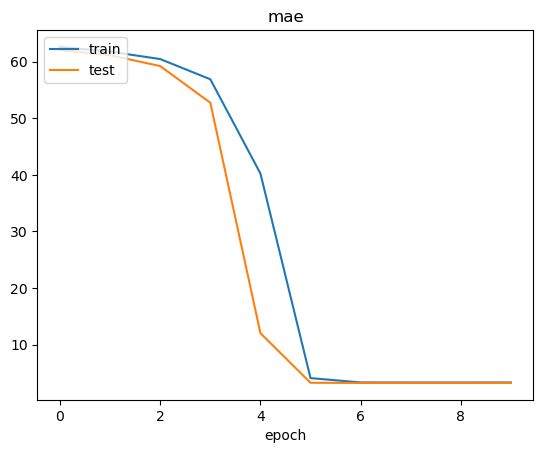

In [71]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['train','test'],loc = 'upper left')
plt.title('mae')
plt.xlabel('epoch')
plt.show()

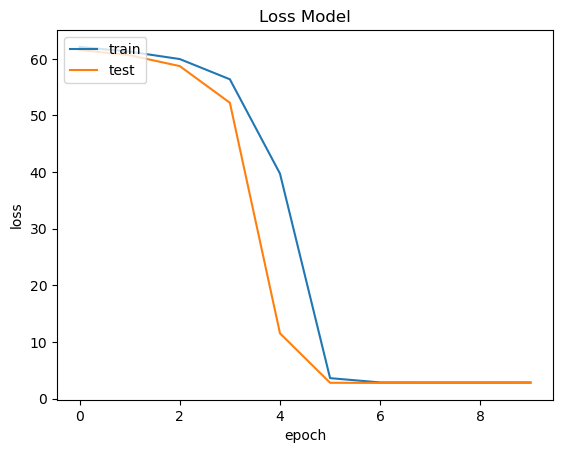

In [72]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','test'],loc = 'upper left')
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()